In [518]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('data.txt', sep='\t')
df['room'] = df['building'].apply(lambda x: x.title()) + ' ' + df['room'].apply(lambda x: f"{x:.0f}")
df = df.drop(columns='building')
df['area'] = df['width (in)'] * df['length (in)'] 
df['height from chair (in)'] = df['height from floor (in)'] - df['chair height (in)']
df.head(5)

room  width (in)  length (in)  height from floor (in)   
0  Recitation Hall 101      18.500      11.1875                   27.75  \
1     Purnell Hall 115      10.000      11.5000                   23.00   
2     Purnell Hall 227      16.500      11.5000                   28.00   
3       Ewing Hall 204      18.125      11.5000                   27.00   
4        Gore Hall 308      14.750      11.7500                   29.50   

   chair height (in) room type  Room Count       area  height from chair (in)  
0             17.375      LCTR           1  206.96875                  10.375  
1             16.250       AUD           1  115.00000                   6.750  
2             17.000      LCTR           1  189.75000                  11.000  
3             17.250      FLEX           1  208.43750                   9.750  
4             18.250      LCTR           1  173.31250                  11.250

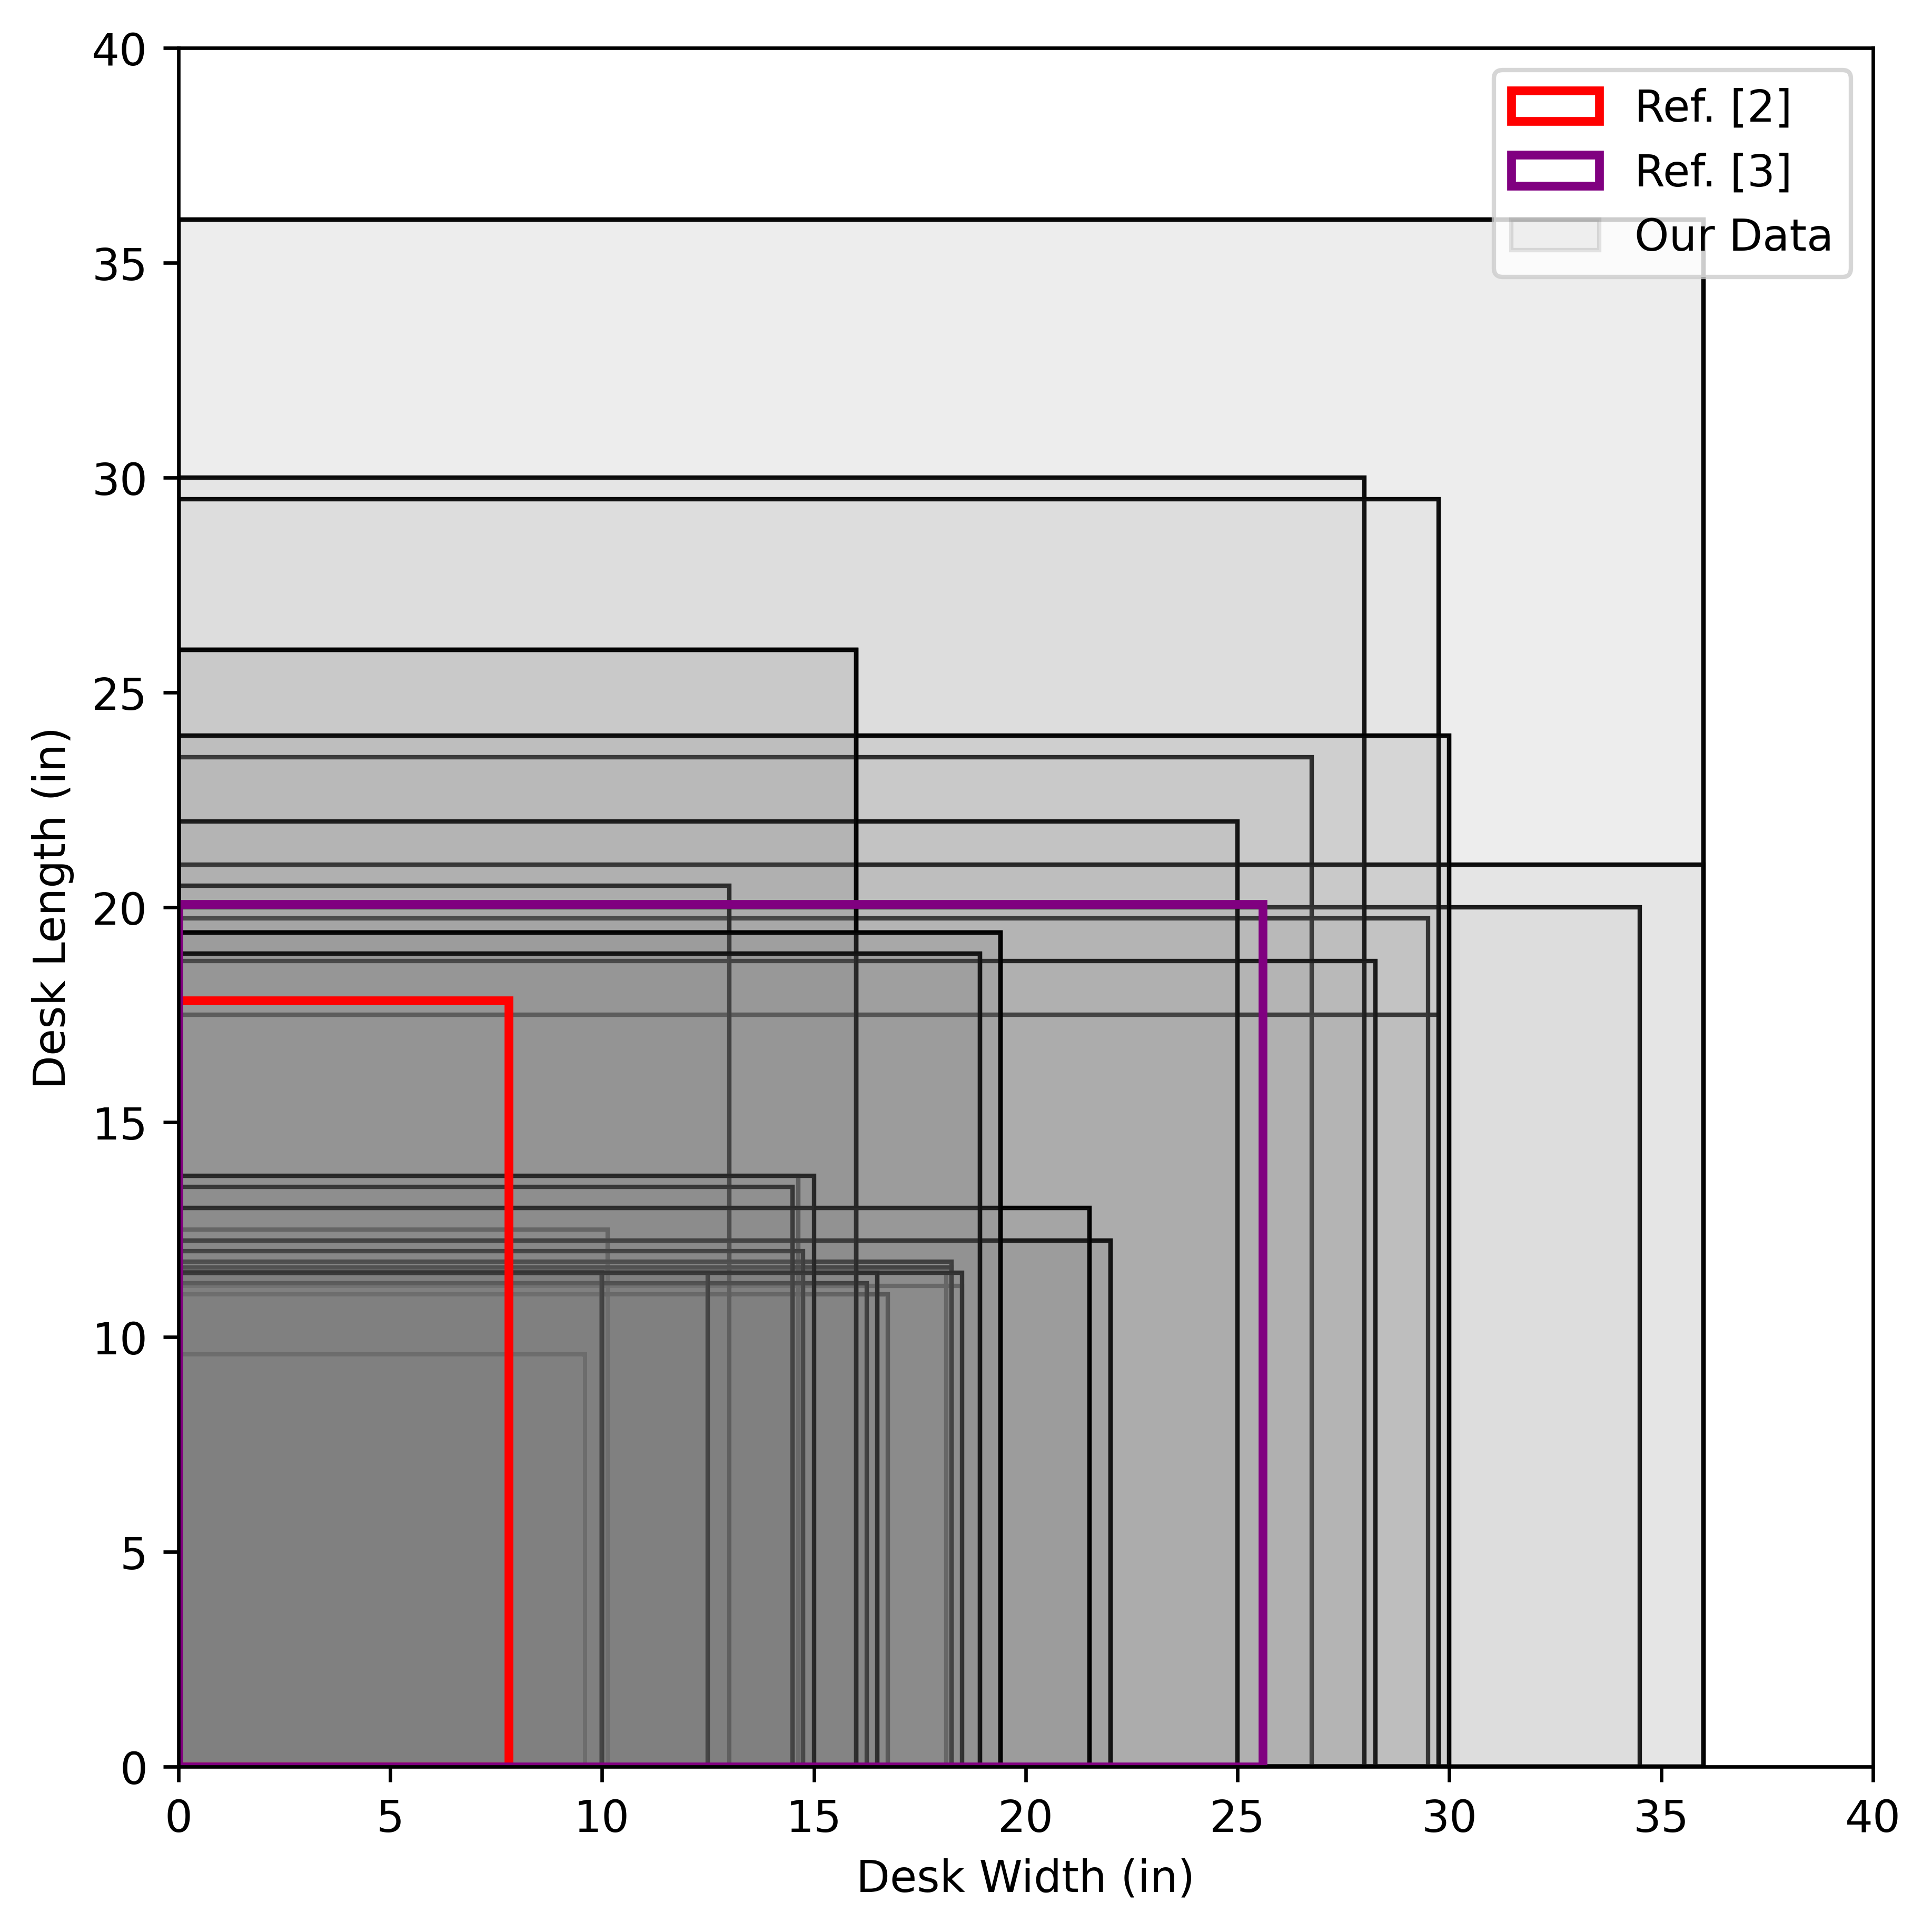

In [519]:
desk_width = np.array(df['width (in)']) 
desk_length = np.array(df['length (in)']) 
count = np.array(df['Room Count'])


fig,ax = plt.subplots(dpi=600, figsize=(6,6), layout='constrained')
ax.set(xlabel='Desk Width (in)', ylabel='Desk Length (in)', xlim=(0, 40), ylim=(0,40))

color = np.array((151, 204, 231)) / 255

for w, l in zip(desk_width, desk_length):
    if w > 0 and l > 0:  
        rect = plt.Rectangle((0, 0), w, l, facecolor='none', edgecolor='black', label='_nolegend_')
        ax.add_patch(rect)
        rect = plt.Rectangle((0, 0), w, l, facecolor='grey', edgecolor='none', label='_nolegend_', alpha=0.07)
        ax.add_patch(rect)

literature_width = np.array([19.8, 65.0]) / 2.54
literature_length = np.array([45.3, 51.0]) / 2.54

for w, l, color in zip(literature_width, literature_length, ['red', 'purple']):
    if w > 0 and l > 0:  
        rect = plt.Rectangle((0, 0), w, l, facecolor='none', edgecolor=color, lw=2)
        ax.add_patch(rect)

rect = plt.Rectangle((-0.1, -0.1), 0.1, 1.1, facecolor='grey', edgecolor='black',  alpha=0.1)
ax.add_patch(rect)

plt.legend(['Ref. [2]', 'Ref. [3]', 'Our Data'])
plt.savefig('rectangles.pdf')

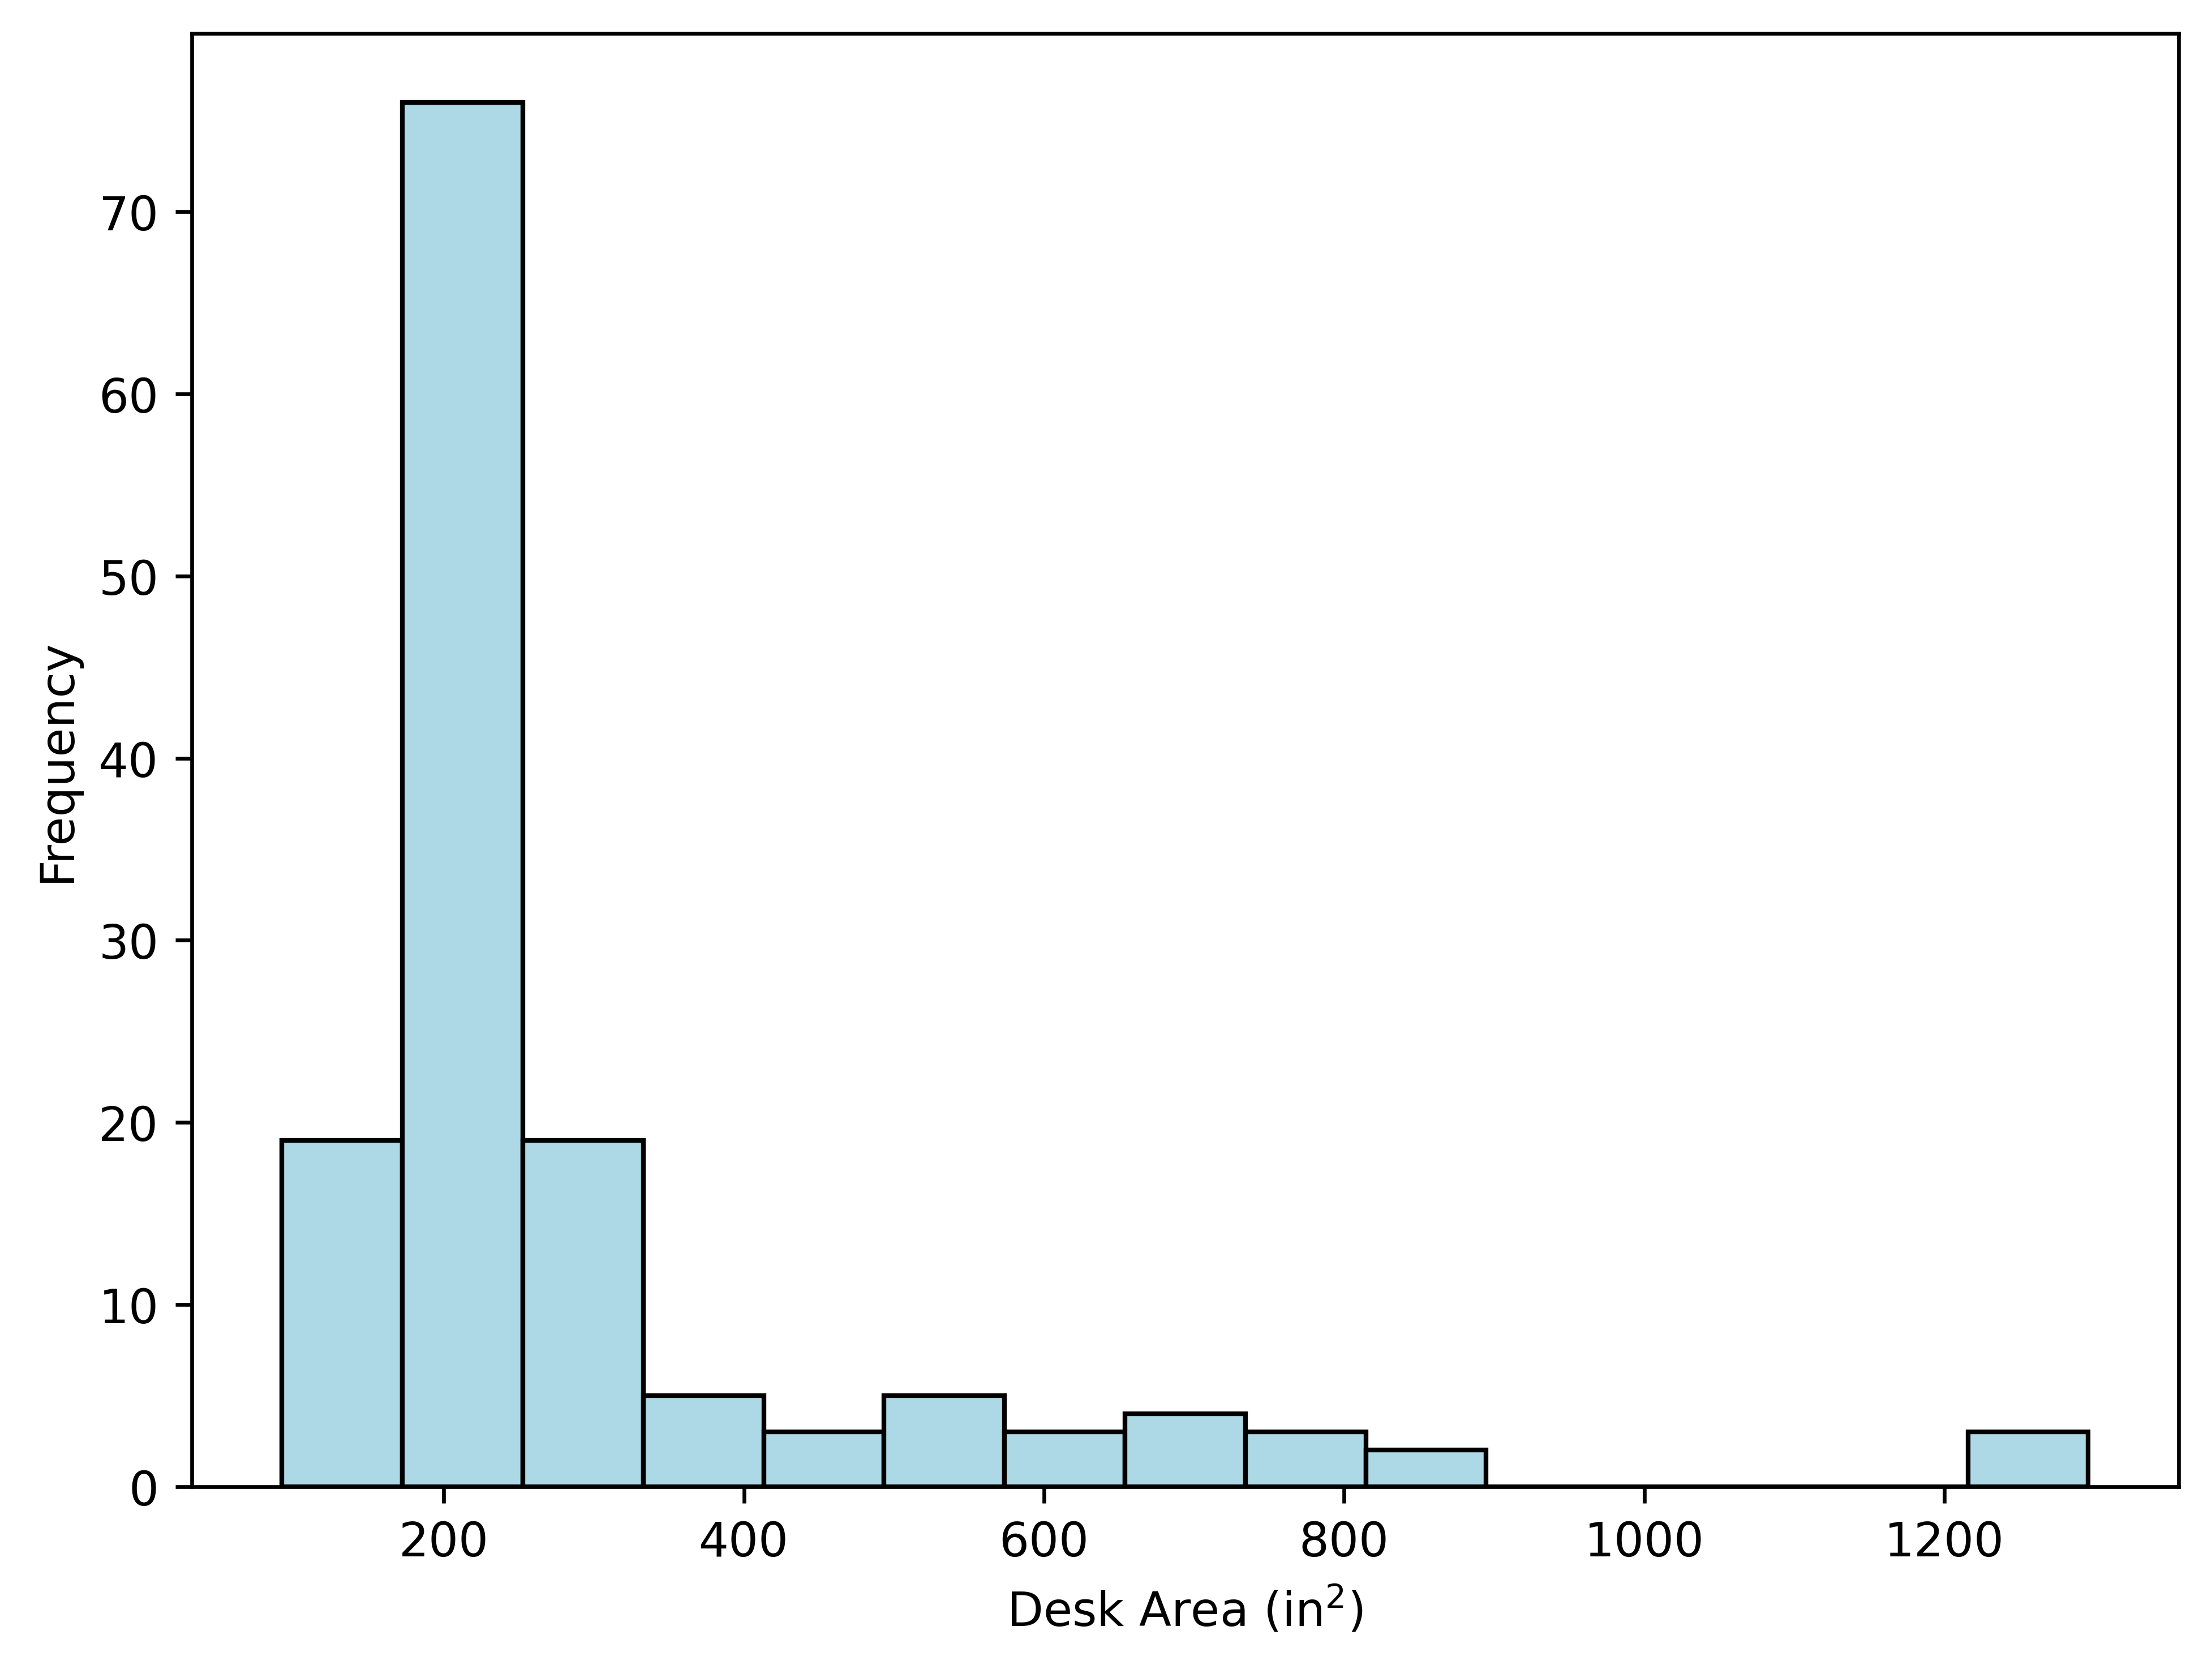

In [520]:
area = desk_width * desk_length 
area = np.repeat(area, count)
fig,ax = plt.subplots(layout='constrained', dpi=600)
ax.hist(area, facecolor='lightblue', edgecolor='black', bins=15)
ax.set(xlabel='Desk Area (in$^2$)', ylabel='Frequency')
plt.savefig('hist.pdf')
plt.savefig('hist.png')

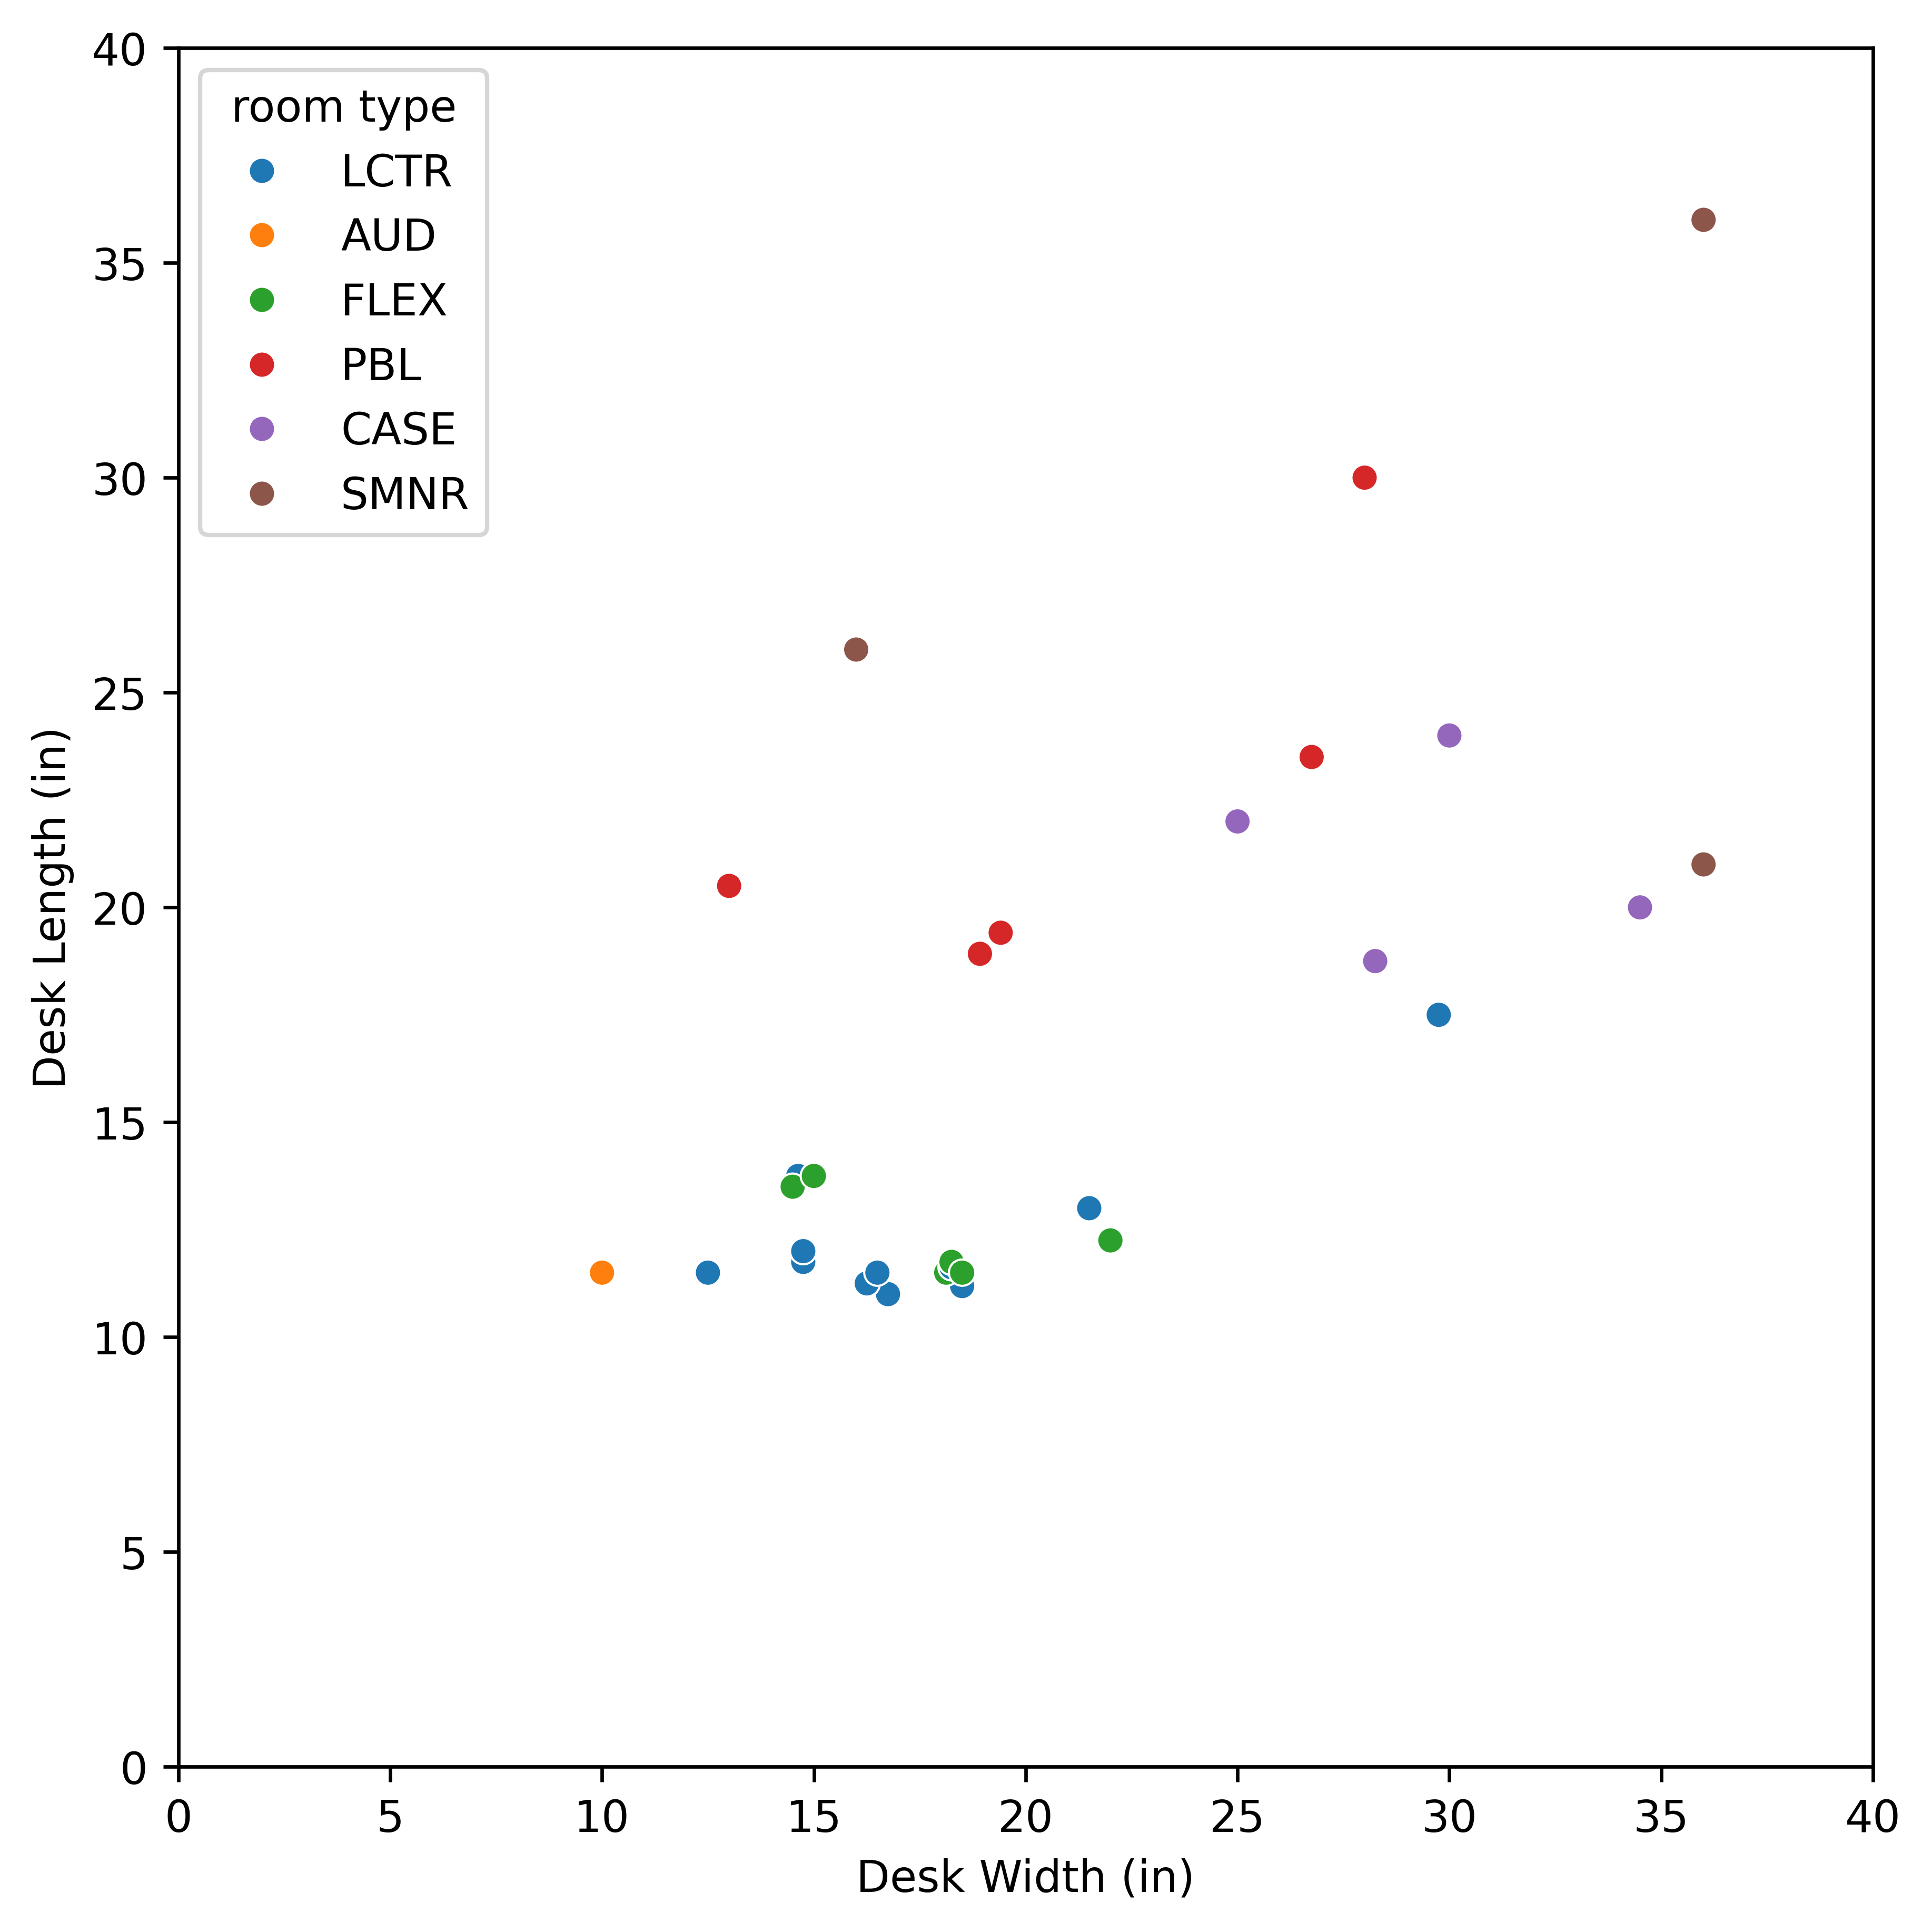

In [521]:
import seaborn as sns
fig,axs = plt.subplots(figsize=(6,6),dpi=600, layout='constrained')
sns.scatterplot(data=df, x='width (in)', y='length (in)', hue='room type', ax=axs)
axs.set(xlabel='Desk Width (in)', ylabel='Desk Length (in)', xlim=(0, 40), ylim=(0,40))
plt.savefig('categorical_lw.pdf')
plt.savefig('categorical_lw.png')

visually don't look cluster... could do kmeans or something but NO

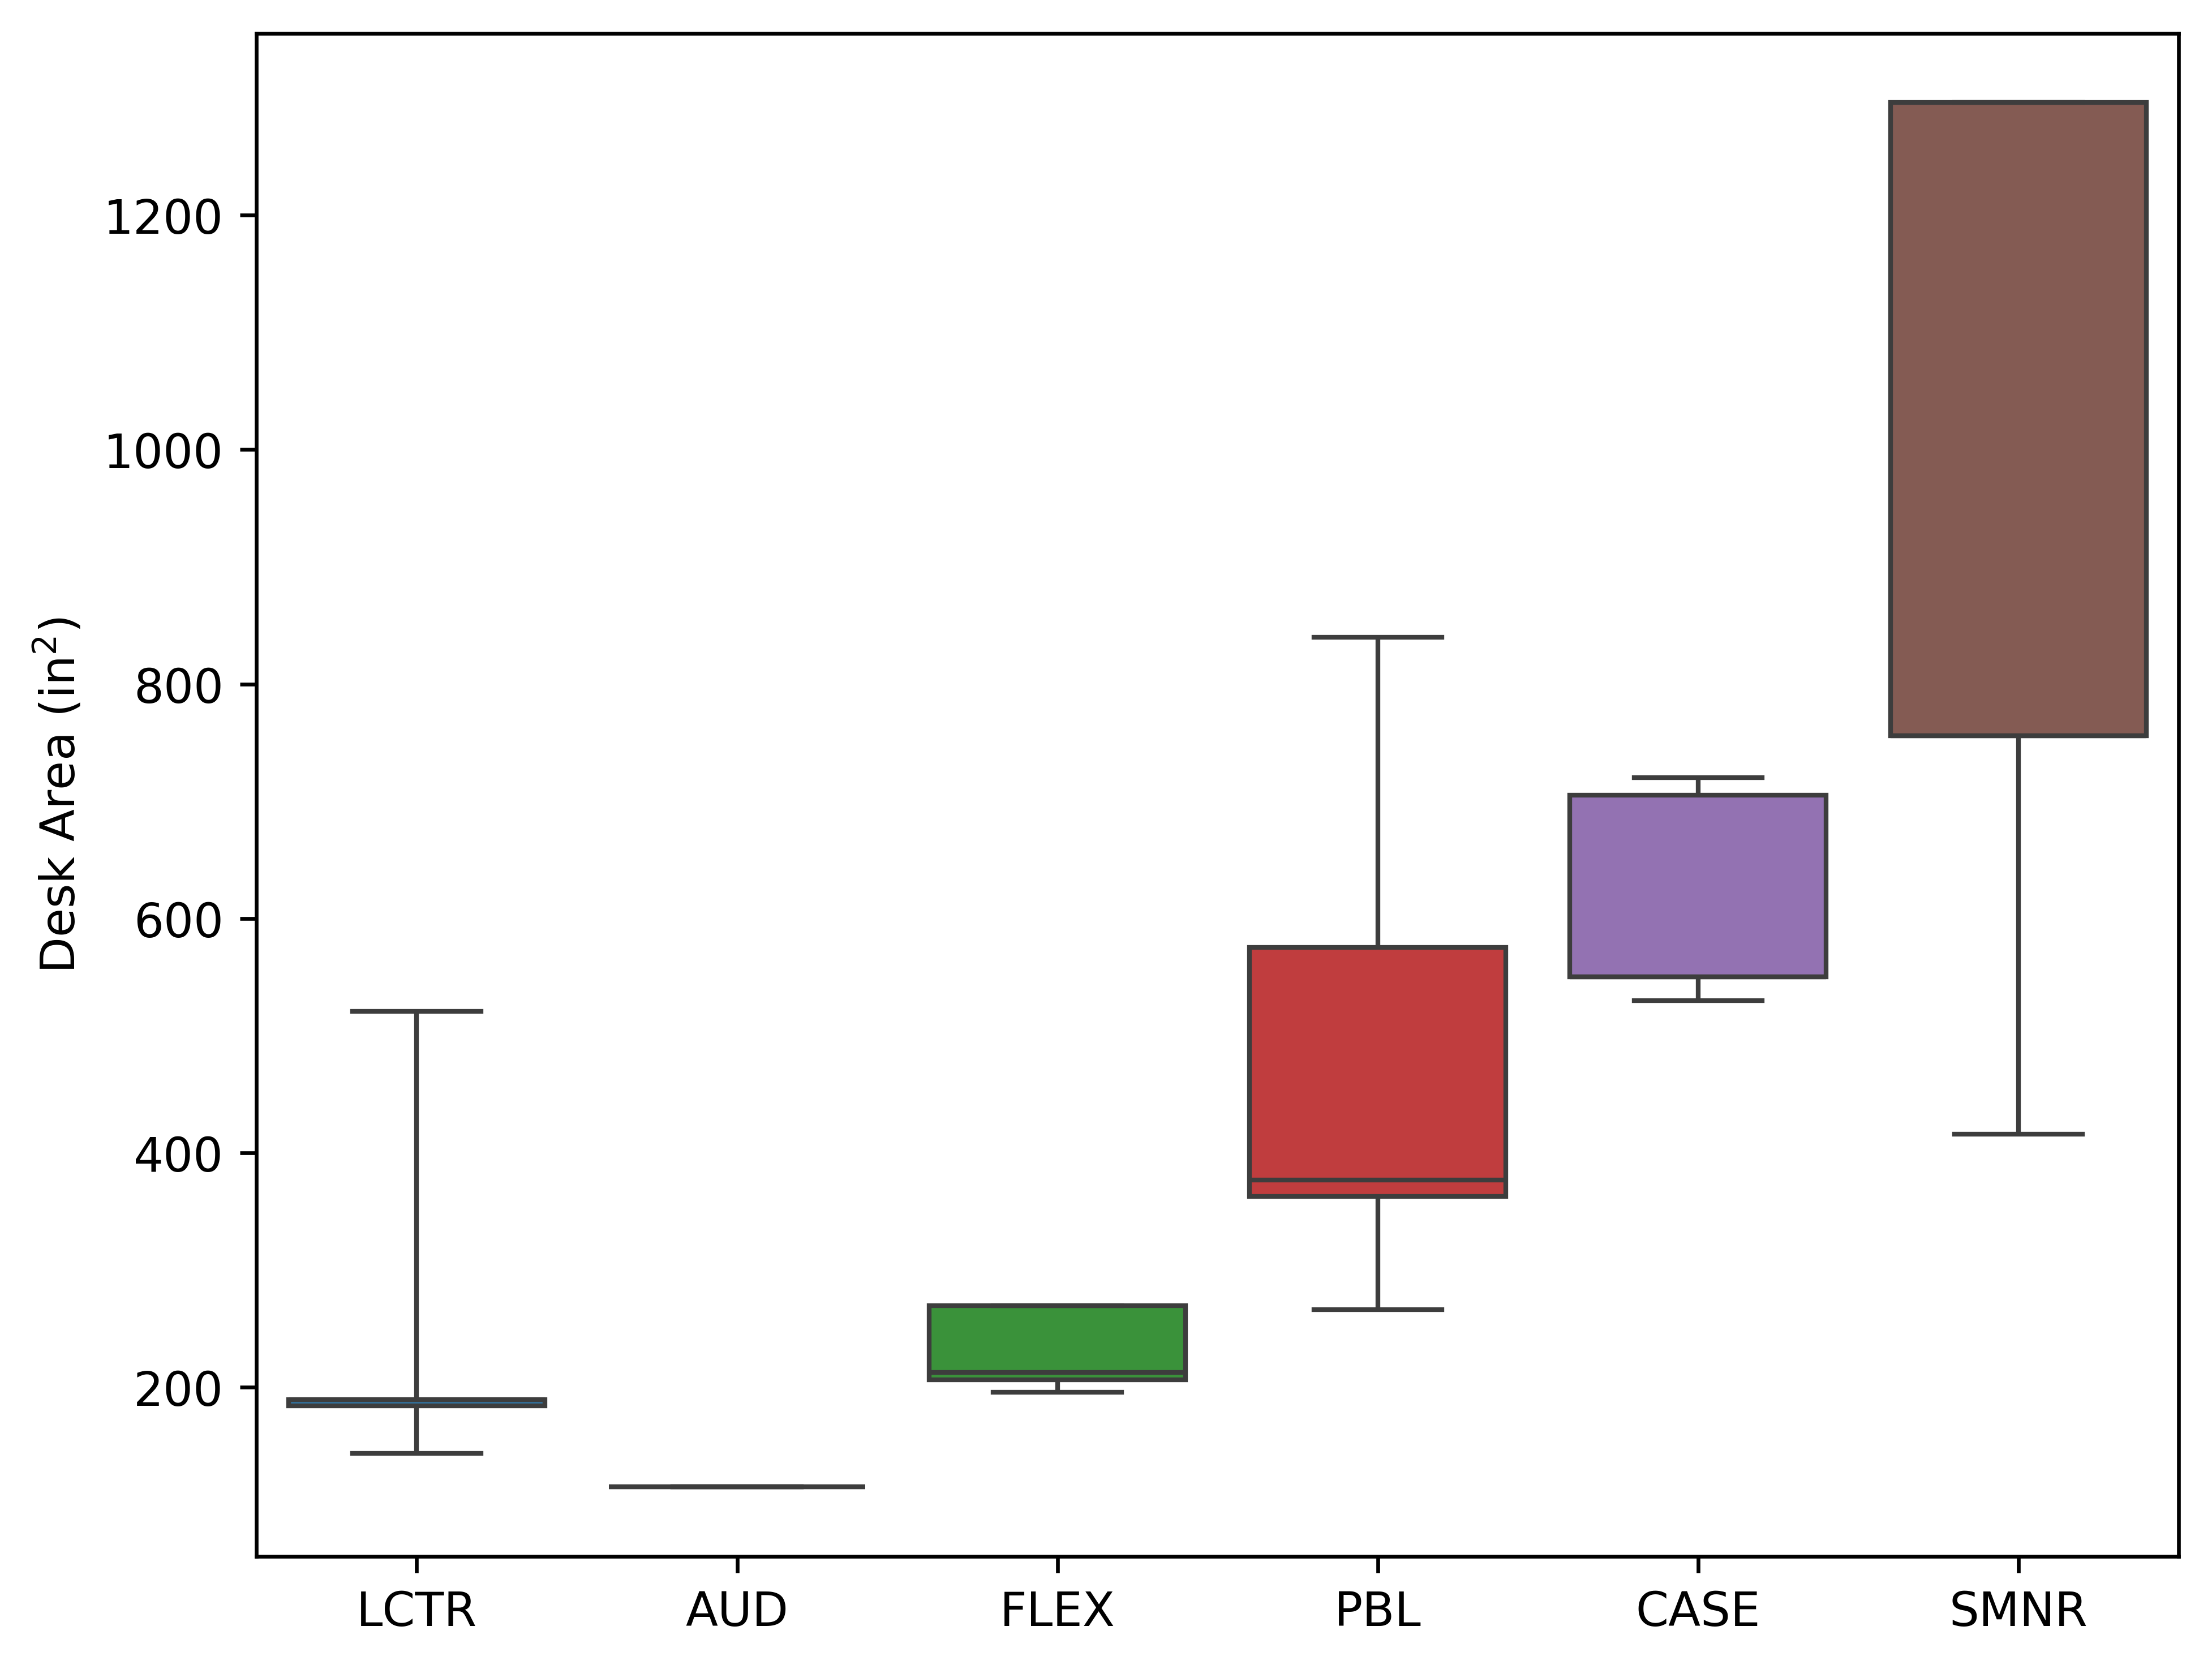

In [522]:
fig,axs = plt.subplots(dpi=600, layout='constrained')

room_type = np.array(df['room type'])
area = np.array(df['area'])

room_type = np.repeat(room_type, count)
area = np.repeat(area, count)

sns.boxplot(x=room_type, y=area, hue=room_type, ax=axs, whis=95.0)
axs.get_legend().remove()
plt.ylabel('Desk Area (in$^2$)')
plt.savefig('boxplots.pdf')

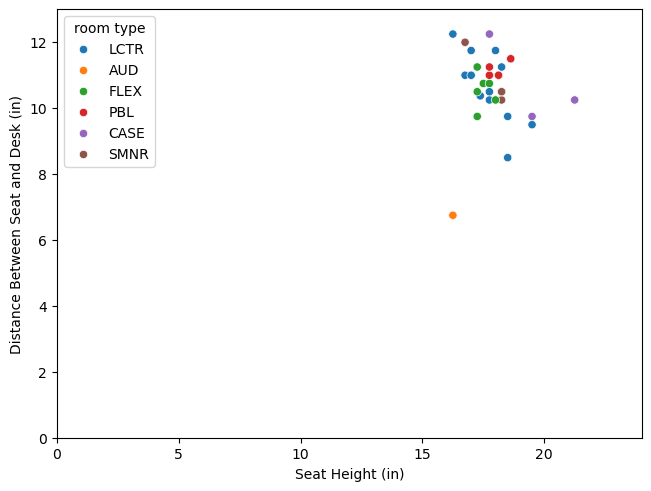

In [523]:
fig,axs = plt.subplots(layout='constrained')
sns.scatterplot(data=df, y='height from chair (in)', x='chair height (in)', hue='room type')
plt.ylim(0,13)
plt.xlim(0,24)
plt.ylabel('Distance Between Seat and Desk (in)')
plt.xlabel('Seat Height (in)')
plt.savefig('height vs width.pdf')
plt.savefig('height vs width.png')

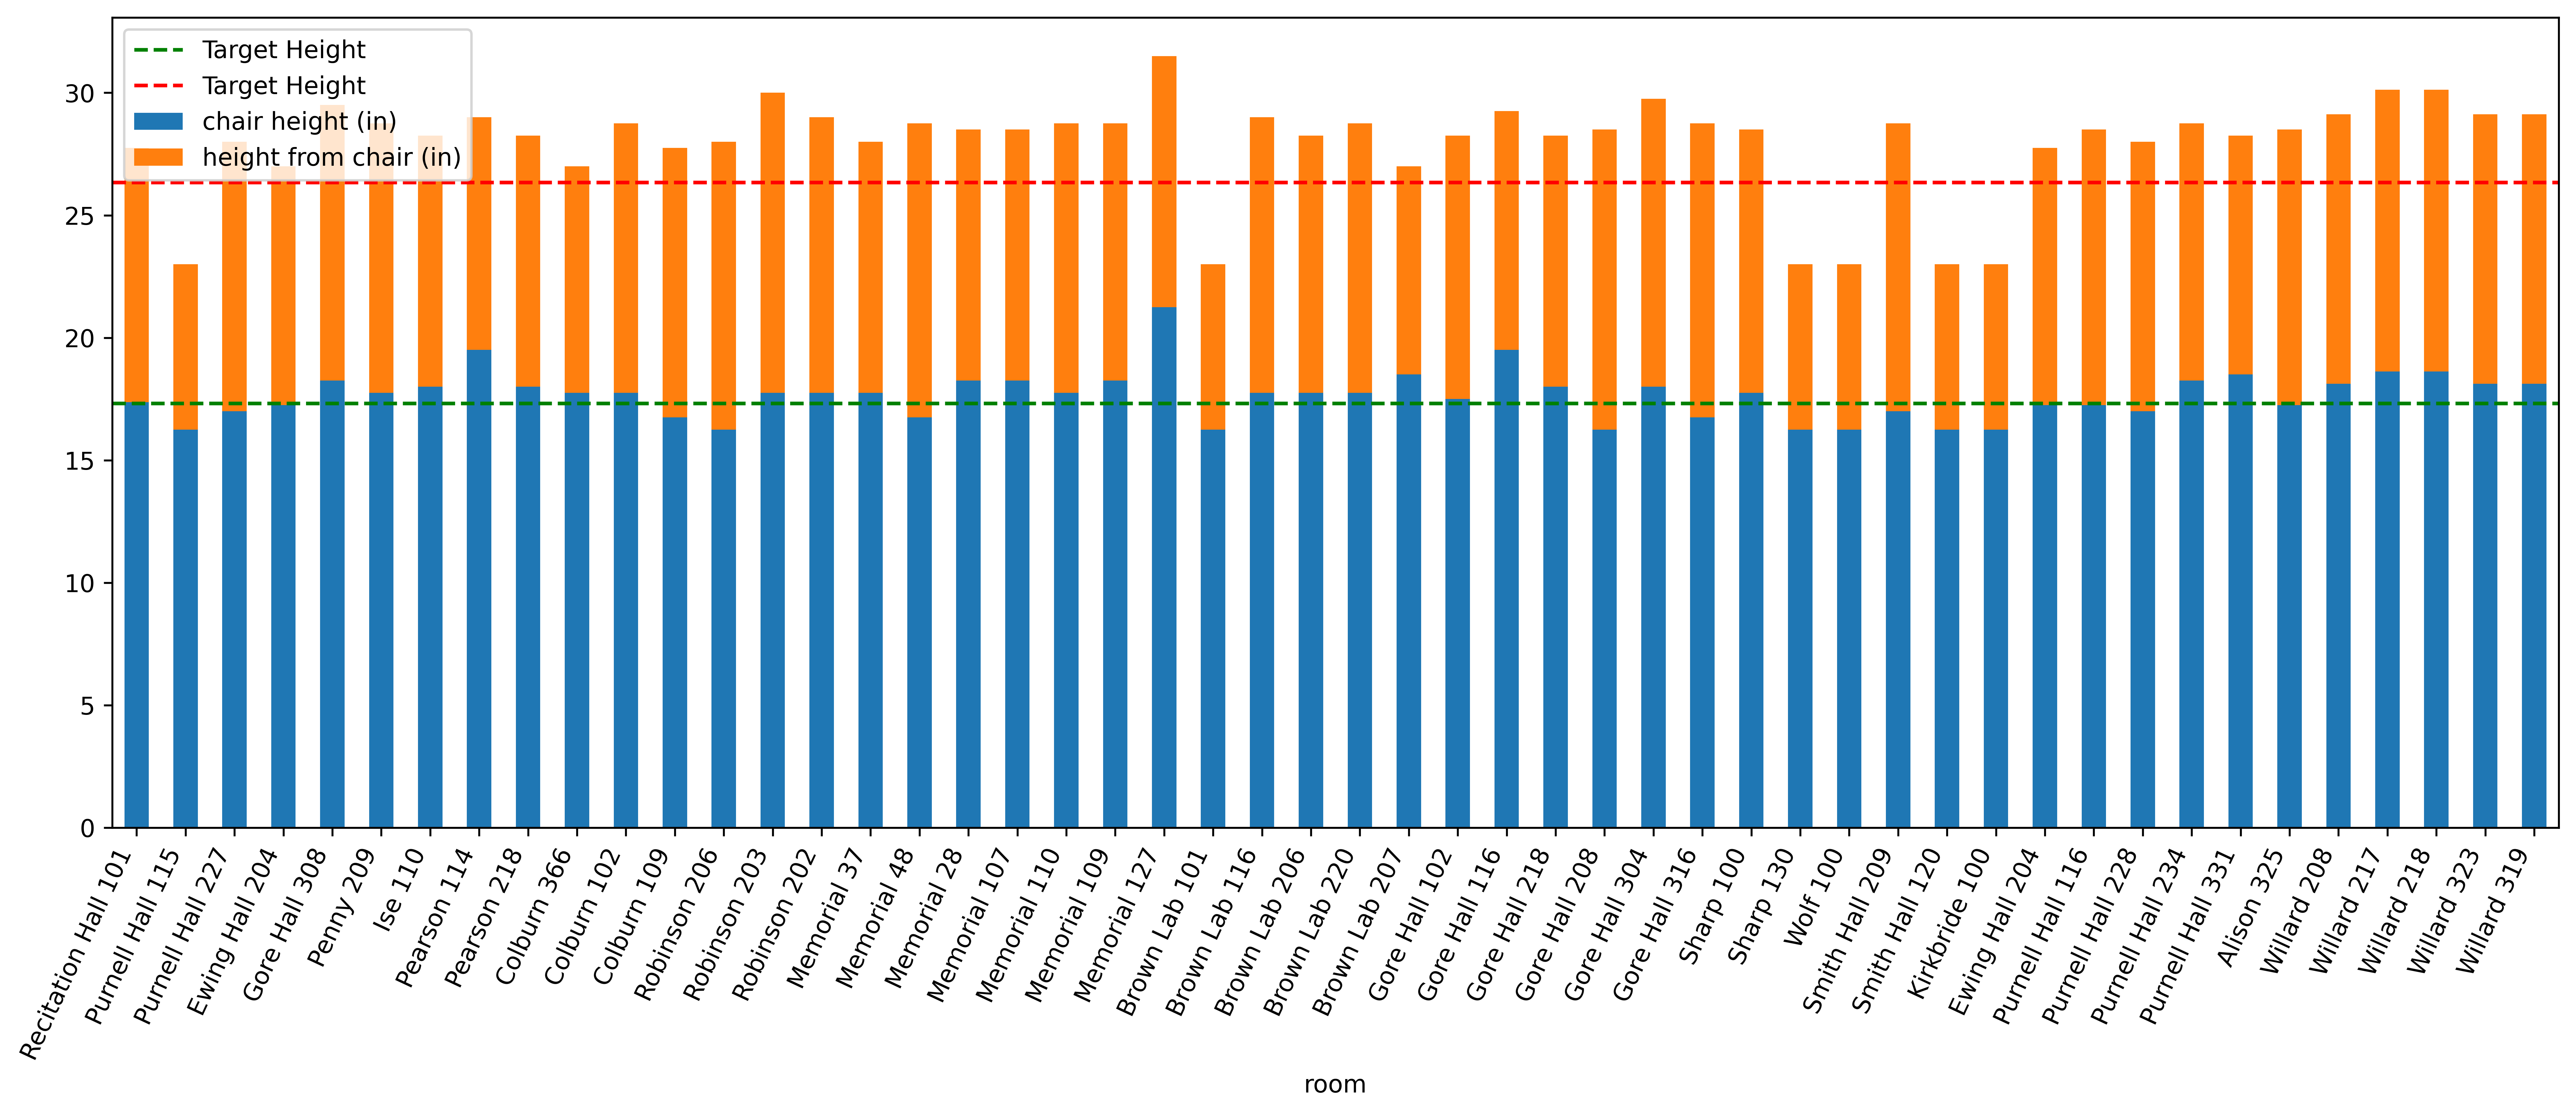

In [524]:
fig,ax = plt.subplots(figsize=(18,6), dpi=600)
df.set_index('room')[['chair height (in)', 'height from chair (in)']].plot(kind='bar', stacked=True, ax=ax)
ax.axhline(y=44/2.54, color='green', linestyle='--', label='Target Height')
ax.axhline(y=22.9/2.54 + 44/2.54, color='red', linestyle='--', label='Target Height')
plt.xticks(rotation=65, ha='right');
ax.legend()
plt.savefig('bar thing.pdf')
plt.savefig('bar thing.png')


In [525]:
def find_closest_entry(df, inp_array, k=1):
    width, length, height,chair_height = inp_array
    query = np.array([width, length, height, chair_height])
    
    X = df[['width (in)', 'length (in)', 'height from chair (in)', 'chair height (in)']].values
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)

    # typical ml process of scaling so the different magnitudes of the numbers doesn't ruin our distance calculation
    X_scaled = (X - X_mean) / X_std
    query_scaled = (query - X_mean) / X_std
    
    distances = np.sqrt(np.sum((X_scaled - query_scaled)**2, axis=1))
    
    indices = np.argpartition(distances, k)[:k]
    return distances

ref2 = np.array([19.8, 45.3, 22.9, 44.5]) / 2.54
ref3 = np.array([65.0, 51.0, 22.9, 44.0]) / 2.54
df['distance'] = find_closest_entry(df, ref2)

In [526]:
styled_df = df.drop(columns=['area', 'height from chair (in)']).style.hide(axis='index').format(precision=2)
styled_df.to_latex('table.tex')

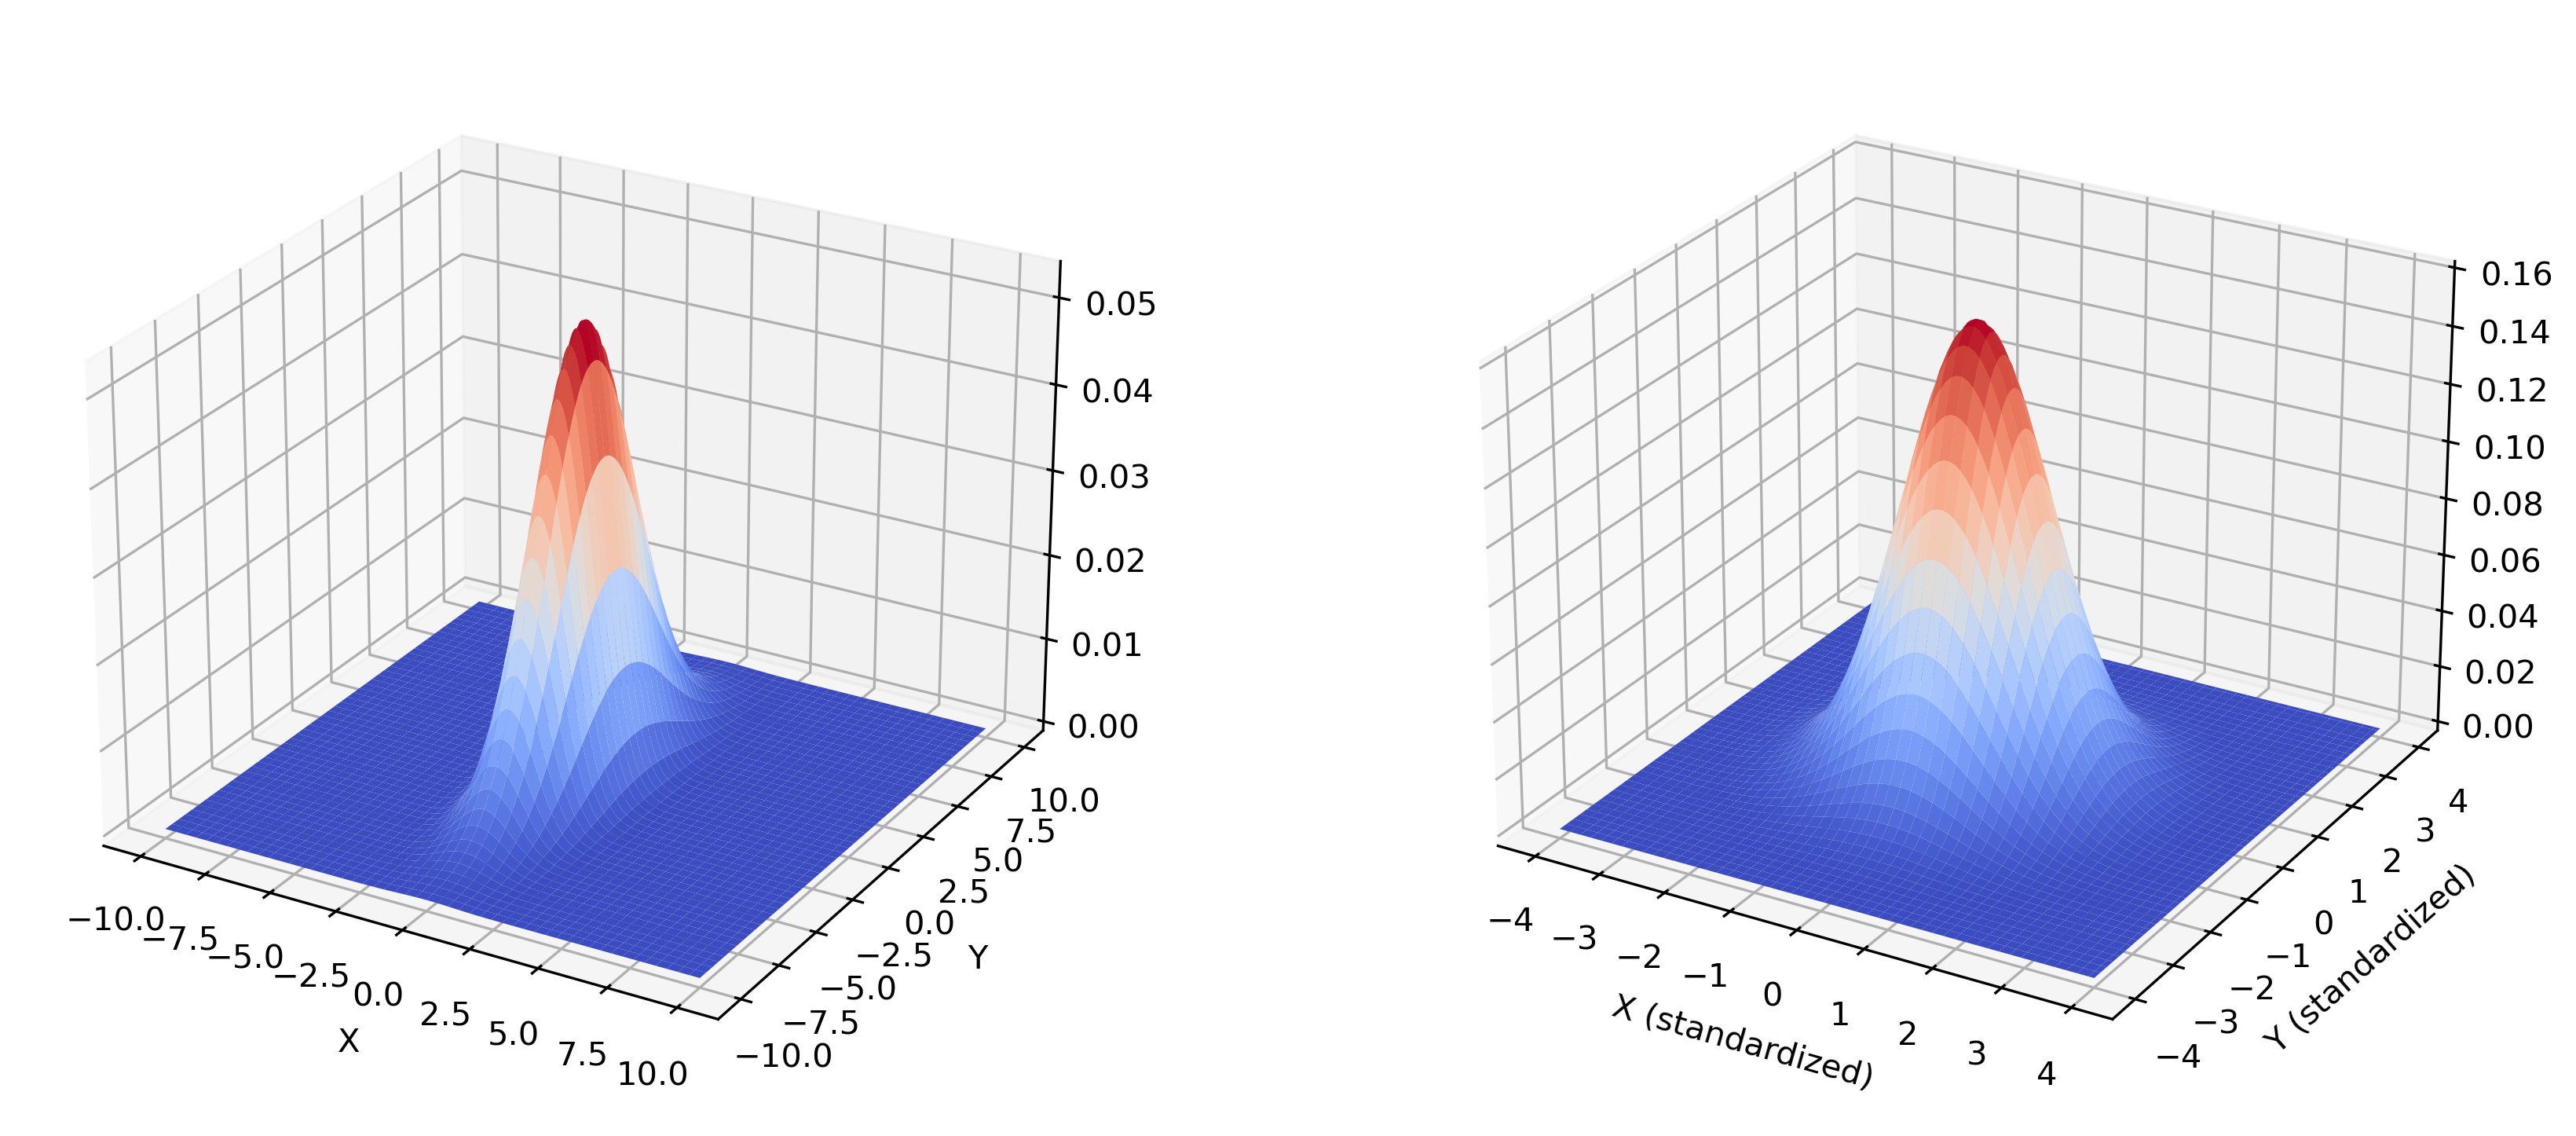

In [527]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler

# Define grid for surface plots
x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

mean = [0, 0]
cov = [[1, 0], [0, 9]]  # Uncorrelated but different variance
rv_raw = multivariate_normal(mean, cov)
Z_raw = rv_raw.pdf(pos)

samples = np.random.multivariate_normal(mean, cov, size=100000)
scaler = StandardScaler()
samples_norm = scaler.fit_transform(samples)

x_norm = np.linspace(-4, 4, 100)
y_norm = np.linspace(-4, 4, 100)
X_norm, Y_norm = np.meshgrid(x_norm, y_norm)
pos_norm = np.dstack((X_norm, Y_norm))

mean_norm = [0, 0]
cov_norm = np.cov(samples_norm.T)
rv_norm = multivariate_normal(mean_norm, cov_norm)
Z_norm = rv_norm.pdf(pos_norm)

# Plotting
fig = plt.figure(figsize=(14, 6), dpi=300)

# Unnormalized surface
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z_raw, cmap='coolwarm', edgecolor='none')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.view_init(elev=25.)

# Normalized surface
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_norm, Y_norm, Z_norm, cmap='coolwarm', edgecolor='none')
ax2.set_xlabel('X (standardized)')
ax2.set_ylabel('Y (standardized)')
ax2.view_init(elev=25.)

In [528]:
rooms = [
    'Smith Hall 209',
    'Recitation Hall 101',
    'Colburn 109',
    'Colburn 366',
    'Penny 209',
    'Gore Hall 102',
    'Sharp 130',
    'Kirkbride 100',
    'Alison 325',
    'Memorial 127',
]

df2 = df.set_index('room').loc[rooms]

[Text(0, 0.5, '(inches)')]

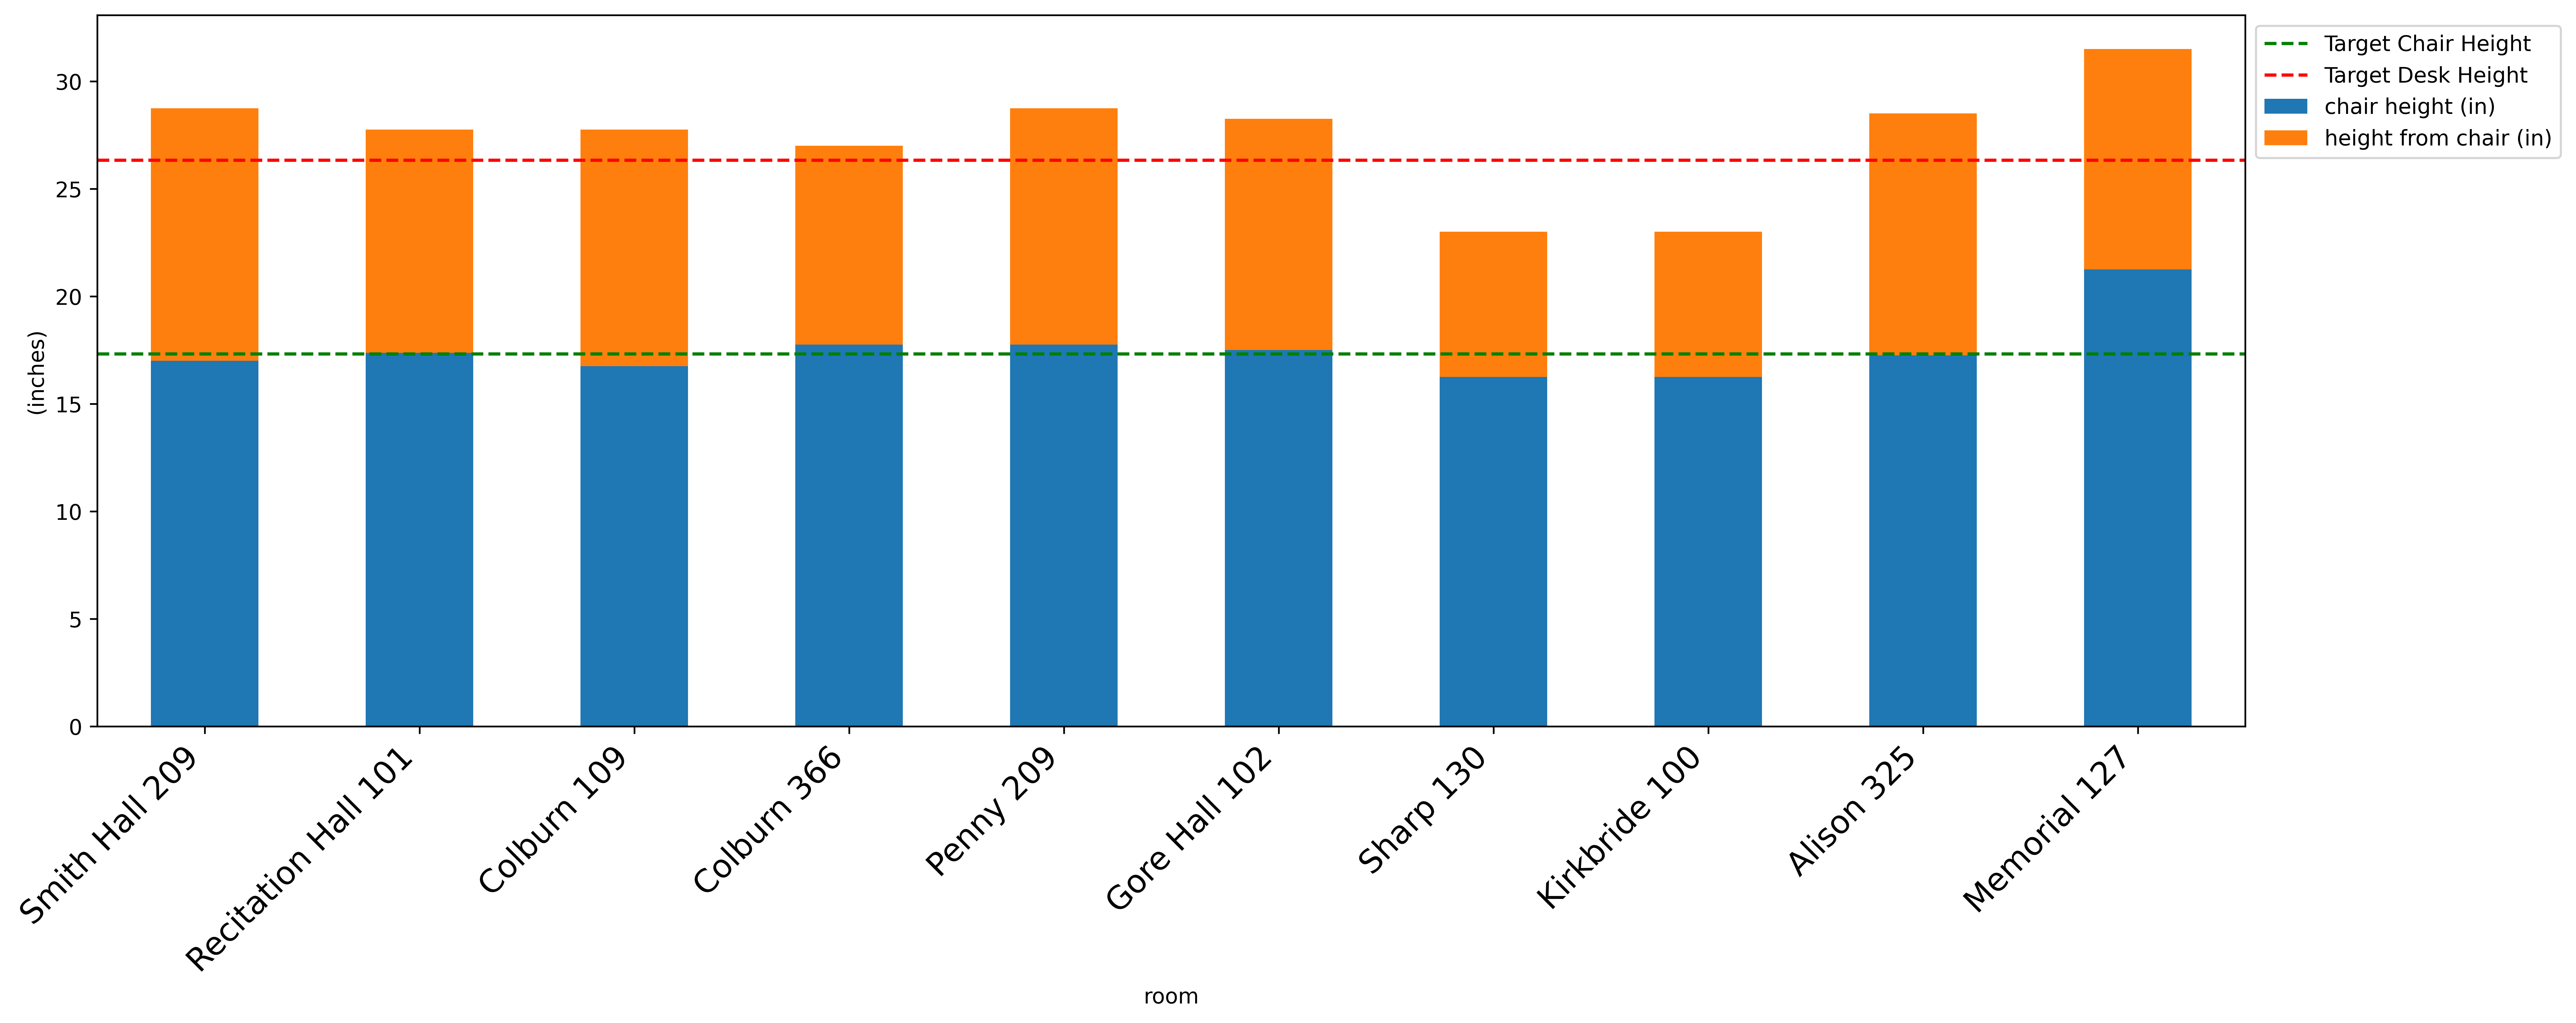

In [529]:
fig,ax = plt.subplots(figsize=(18,6), dpi=600)
df2[['chair height (in)', 'height from chair (in)']].plot(kind='bar', stacked=True, ax=ax)
ax.axhline(y=44/2.54, color='green', linestyle='--', label='Target Chair Height')
ax.axhline(y=22.9/2.54 + 44/2.54, color='red', linestyle='--', label='Target Desk Height')
plt.xticks(rotation=45, ha='right', fontsize=15);
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set(ylabel='(inches)')

In [1]:
from scipy.constants import R
T = 273.15+25
R*T/35.6

69.63362442703337